In [2]:
#Importing necessary packages
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input

# Dataset


Dataset used is from https://www.kaggle.com/datasets/saadbutt321/pakistan-sign-language-dataset.
There are total 37 characters (or classes). Each character has 40 images on average.
The dataset is divided into train and validation set such that there are 30 images on average in train set for each character and 10 images in validation set. 
The dataset is stored such that there is one parent or base folder, named 'PSL_DATA'. There are two sub folders in PSL_DATA, namely 'TRAIN' and 'TEST'. Each sub-folder contains 37 folders for 37 Pakistani sign language characters. 
(This dataset splitting is done manually)

In [6]:
#creating directories to access dataset
base_dir = 'PSL_DATA'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Test')

Since the dataset is very small, data augmentaion is performed using the ImageDataGenerator. The ImageDataGenerator is a class provided by Keras that allows to perform real-time data augmentation and data preprocessing for image data during model training. Augmentation is applied on train set.

In [14]:
# Adding data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

#Validation set is only rescaled for suitable dimensions. 
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [16]:
# creating data generator objects to obtain images

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'categorical', target_size = (224, 224))


Found 1149 images belonging to 37 classes.
Found 370 images belonging to 37 classes.


# Model 1: VGG16

The first model used is VGG16. odel is imported and then downloaded with input shape as as the shape of the images. The next parameter is set false to leave the last fully connected model. This is because, we only need to classify 37 classes while this model is trained to classify 1000+ classes. The pre-trained weights of imagenet are used.

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [26]:
#making the model non trainable since we need to fine tune the model only.
for layer in base_model.layers:
    layer.trainable = False

## Fine Tuning of VGG16:

In [27]:
# Flattening the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Adding a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Adding a dropout rate of 0.5 to avoid overfitting
x = layers.Dropout(0.5)(x)

# Adding a final softmax layer with 37 node for classification output
x = layers.Dense(37, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.summary()

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [28]:
vgghist = model.fit(train_generator, validation_data = validation_generator, epochs = 10)

Epoch 1/10
58/58 [==============================] - 774s 13s/step - loss: 3.6453 - accuracy: 0.0688 - val_loss: 2.9685 - val_accuracy: 0.2351
Epoch 2/10
58/58 [==============================] - 768s 13s/step - loss: 3.1107 - accuracy: 0.1775 - val_loss: 2.2825 - val_accuracy: 0.5541
Epoch 3/10
58/58 [==============================] - 768s 13s/step - loss: 2.7308 - accuracy: 0.2515 - val_loss: 1.8287 - val_accuracy: 0.6622
Epoch 4/10
58/58 [==============================] - 767s 13s/step - loss: 2.4265 - accuracy: 0.3325 - val_loss: 1.5047 - val_accuracy: 0.7135
Epoch 5/10
58/58 [==============================] - 776s 13s/step - loss: 2.2119 - accuracy: 0.3951 - val_loss: 1.2370 - val_accuracy: 0.7676
Epoch 6/10
58/58 [==============================] - 1102s 19s/step - loss: 1.8963 - accuracy: 0.4708 - val_loss: 1.0351 - val_accuracy: 0.8432
Epoch 7/10
58/58 [==============================] - 1223s 21s/step - loss: 1.7813 - accuracy: 0.5065 - val_loss: 0.8238 - val_accuracy: 0.8405
Epoc

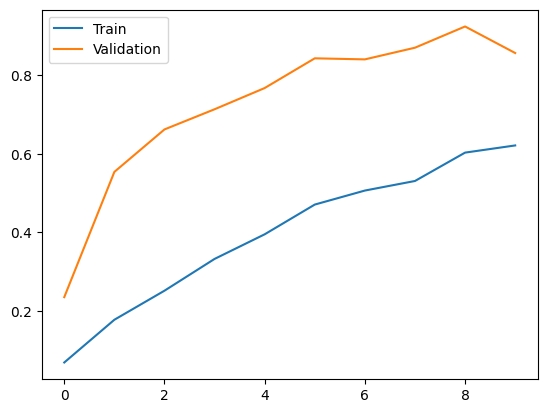

In [31]:
#Plotting the learning curves for train and test accuracy for VGG model
plt.plot(vgghist.history['accuracy'], label='Train')
plt.plot(vgghist.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

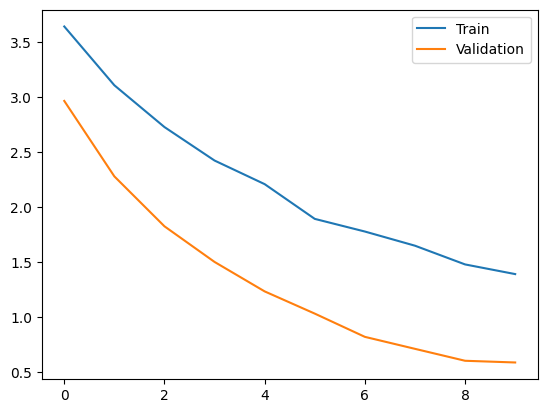

In [33]:
#Plotting the learning curves for train and test loss of VGG Model
plt.plot(vgghist.history['loss'], label='Train')
plt.plot(vgghist.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [34]:
# Evaluate the model on the training data using the train_generator
train_loss, train_accuracy = model.evaluate(train_generator)
print(f'Train loss is {train_loss:0.3f} and train accuracy is {train_accuracy*100:.1f}%')

# Evaluate the model on the validation data using the validation_generator
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Validation loss is {validation_loss:0.3f} and validation accuracy is {validation_accuracy*100:.1f}%')

58/58 [==============================] - 1111s 19s/step - loss: 0.7258 - accuracy: 0.8599
Train loss is 0.726 and train accuracy is 86.0%
19/19 [==============================] - 335s 18s/step - loss: 0.4009 - accuracy: 0.9405
Validation loss is 0.401 and validation accuracy is 94.1%


# Model 2: EfficientNet

In [39]:
#Installing the model
!pip install -U efficientnet

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 50.7/50.7 kB 518.8 kB/s eta 0:00:00


In [40]:
#importing the model
import efficientnet.keras as efn

In [41]:
#using B0 version of EfficientNet
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

16804768/16804768 [==============================] - 29s 2us/step


In [42]:
#making the model non trainable since we need to fine tune the model only.
for layer in base_model.layers:
    layer.trainable = False

## Fine Tuning of EfficientNet

In [45]:
x = base_model.output

# Flattening the output layer to 1 dimension
x = layers.Flatten()(x)

# Adding a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation="relu")(x)

# Adding a dropout rate of 0.5 to avoid overfitting
x = layers.Dropout(0.5)(x)

# Adding a final softmax layer with 37 node for classification output
predictions = layers.Dense(37, activation="softmax")(x)

model_final = Model(base_model.input, predictions)

model_final.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                           

 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 144)  0          ['block2b_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_s

 block4b_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (FixedDropout)    (None, 14, 14, 80)   0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_a

 block5a_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 14, 14, 672)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6a_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block6a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6a_expand_activation (Act  (None, 14, 14, 672)  0          ['block6a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, 7, 7, 672)   16800       ['block6a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6a_bn (BatchNormalization  (None, 7, 7, 672)   2688        ['block6a_dwconv[0][0]']         
 )        

 )                                                                                                
                                                                                                  
 block6c_activation (Activation  (None, 7, 7, 1152)  0           ['block6c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_s

 block7a_se_squeeze (GlobalAver  (None, 1152)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block7a_activation[0][0]',     
          

In [48]:
# Compiling the model with the Adam optimizer
model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
eff_history = model_final.fit(train_generator, validation_data = validation_generator, epochs = 10)

Epoch 1/10
58/58 [==============================] - 396s 7s/step - loss: 3.2983 - accuracy: 0.3055 - val_loss: 1.1560 - val_accuracy: 0.6378
Epoch 2/10
58/58 [==============================] - 275s 5s/step - loss: 1.7905 - accuracy: 0.5074 - val_loss: 0.5162 - val_accuracy: 0.8270
Epoch 3/10
58/58 [==============================] - 237s 4s/step - loss: 1.3495 - accuracy: 0.6275 - val_loss: 0.4614 - val_accuracy: 0.8324
Epoch 4/10
58/58 [==============================] - 236s 4s/step - loss: 1.1898 - accuracy: 0.6867 - val_loss: 0.2483 - val_accuracy: 0.9297
Epoch 5/10
58/58 [==============================] - 236s 4s/step - loss: 1.0360 - accuracy: 0.7232 - val_loss: 0.2889 - val_accuracy: 0.9054
Epoch 6/10
58/58 [==============================] - 297s 5s/step - loss: 0.9410 - accuracy: 0.7511 - val_loss: 0.1933 - val_accuracy: 0.9568
Epoch 7/10
58/58 [==============================] - 386s 7s/step - loss: 0.8197 - accuracy: 0.7607 - val_loss: 0.2117 - val_accuracy: 0.9297
Epoch 8/10
58

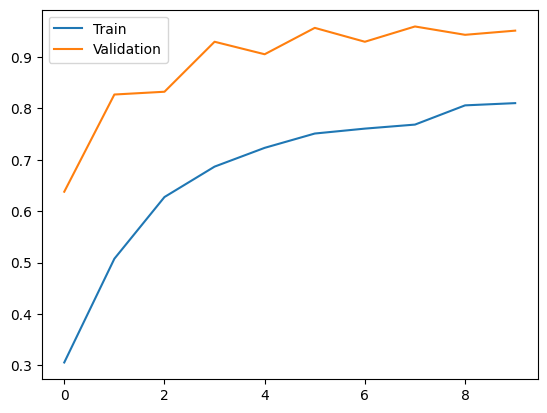

In [51]:
#Plotting the learning curves for train and test accuracy for EfficientNet model
plt.plot(eff_history.history['accuracy'], label='Train')
plt.plot(eff_history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

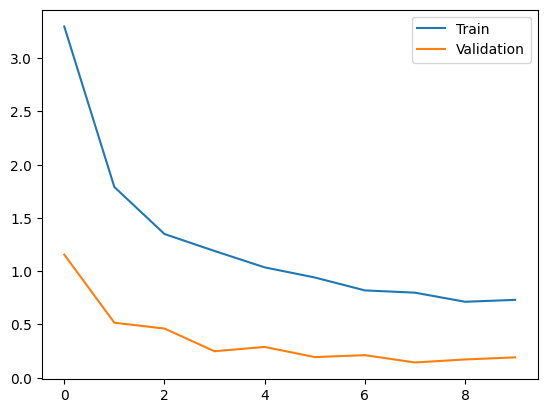

In [52]:
#Plotting the learning curves for train and test loss of EfficientNet Model
plt.plot(eff_history.history['loss'], label='Train')
plt.plot(eff_history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [53]:
# Evaluate the model on the training data using the train_generator
training_loss, training_accuracy = model_final.evaluate(train_generator)
print(f'Train loss is {training_loss:0.3f} and train accuracy is {training_accuracy*100:.1f}%')

# Evaluate the model on the validation data using the validation_generator
val_loss, val_accuracy = model_final.evaluate(validation_generator)
print(f'Validation loss is {val_loss:0.3f} and validation accuracy is {val_accuracy*100:.1f}%')

58/58 [==============================] - 224s 4s/step - loss: 0.3083 - accuracy: 0.9034
Train loss is 0.308 and train accuracy is 90.3%
19/19 [==============================] - 66s 3s/step - loss: 0.1909 - accuracy: 0.9514
Validation loss is 0.191 and validation accuracy is 95.1%


# Comparing Both Models

EfficientNetB0 model works much faster and take much less computational time than VGG16 model. Its accuracy for 10 epochs is very high in comparision to VGG16.

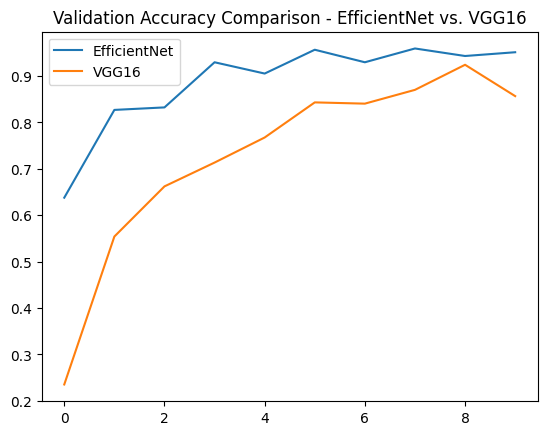

In [54]:
plt.plot(eff_history.history['val_accuracy'], label='EfficientNet')
plt.plot(vgghist.history['val_accuracy'], label='VGG16')
plt.title('Validation Accuracy Comparison - EfficientNet vs. VGG16')
plt.legend()
plt.show()

1/1 [==============================] - 0s 326ms/step


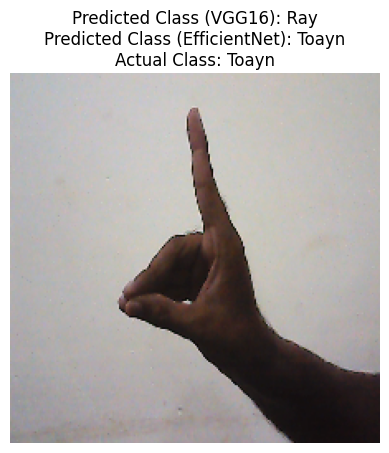

In [67]:
# Loading and preprocess the single image
image_path = 'PSL_DATA/Test/Toayn/U_30.png'
img = load_img(image_path, target_size=(224, 224))
img_vgg = img_to_array(img)
img_eff = np.copy(img_vgg) 
img_vgg = vgg_preprocess_input(img_vgg)
img_eff = eff_preprocess_input(img_eff)


# Making predictions on the single image using the VGG16 model
vgg_predictions = model.predict(np.expand_dims(img_vgg, axis=0))
vgg_predicted_class = np.argmax(vgg_predictions)
vgg_train_classes = sorted(os.listdir(train_dir))
vgg_predicted_class_label = vgg_train_classes[vgg_predicted_class]

# Making predictions on the single image using the EfficientNet model
eff_predictions = model_final.predict(np.expand_dims(img_array_eff, axis=0))
eff_predicted_class = np.argmax(eff_predictions)
eff_train_classes = sorted(os.listdir(train_dir))
eff_predicted_class_label = eff_train_classes[eff_predicted_class]

plt.imshow(img)
plt.title(f'Predicted Class (VGG16): {vgg_predicted_class_label}\nPredicted Class (EfficientNet): {eff_predicted_class_label}\nActual Class: Toayn')
plt.axis('off')
plt.show()
